# Mini-project n° 1 - Who painted this picture?

In [1]:
import PIL
from PIL import Image
import os, sys

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import optuna
from optuna.trial import TrialState

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms, models
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from collections import Counter

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Loading datas

In [3]:
data_path = "./art-challenge/"
if not os.path.isdir(data_path) or not os.listdir(data_path):
    !git clone https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/art-challenge.git
else:
    print("Data already downloaded!")

Data already downloaded!


In [4]:
# Reading CSV
artists = pd.read_csv(data_path + "artists.csv")
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [5]:
# Filtrer pour ne garder que les peintres ayant plus de 85 peintures
artists_filtered = artists.loc[artists['paintings'] > 85].copy()


# Afficher un aperçu du DataFrame filtré
print(artists_filtered.head())


   id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   
5   5       Salvador Dali  1904 - 1989                    Surrealism   
6   6       Edouard Manet  1832 - 1883         Realism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
4     Belgian  René François Ghislain Magritte (French: [ʁəne...   
5     Spanish  Salvador Domingo Felipe Jacinto Dalí i Domènec...   
6      French  Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/

In [6]:
artists_filtered = artists.loc[artists['paintings'] > 85, 'name']
artists_list = artists_filtered.tolist()  # Liste des artistes à garder
artists_list

['Amedeo Modigliani',
 'Vasiliy Kandinskiy',
 'Rene Magritte',
 'Salvador Dali',
 'Edouard Manet',
 'Andrei Rublev',
 'Vincent van Gogh',
 'Gustav Klimt',
 'Hieronymus Bosch',
 'Kazimir Malevich',
 'Mikhail Vrubel',
 'Pablo Picasso',
 'Peter Paul Rubens',
 'Pierre-Auguste Renoir',
 'Francisco Goya',
 'Frida Kahlo',
 'El Greco',
 'Albrecht Dürer',
 'Alfred Sisley',
 'Pieter Bruegel',
 'Marc Chagall',
 'Giotto di Bondone',
 'Sandro Botticelli',
 'Leonardo da Vinci',
 'Diego Velazquez',
 'Henri Matisse',
 'Edgar Degas',
 'Rembrandt',
 'Titian',
 'Camille Pissarro',
 'Paul Klee',
 'Joan Miro',
 'Andy Warhol',
 'Paul Gauguin',
 'Raphael']

## Exploratory data analysis

Nombre total d'artistes : 50
Nombre total de styles : 31


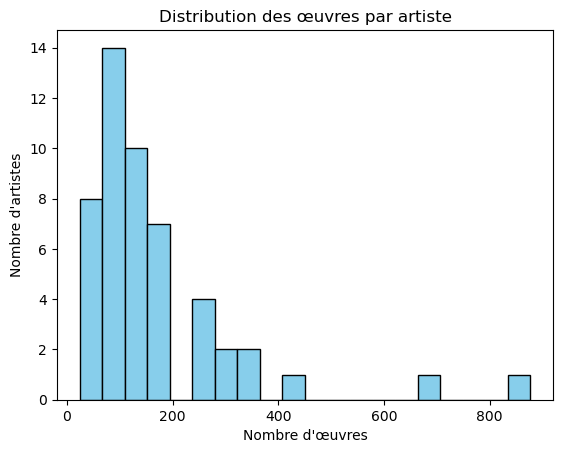

In [7]:
# Analyse descriptive des artistes et des styles
print("Nombre total d'artistes :", artists['name'].nunique())
print("Nombre total de styles :", artists['genre'].nunique())

# Distribution des œuvres par artiste
artists['paintings'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution des œuvres par artiste")
plt.xlabel("Nombre d'œuvres")
plt.ylabel("Nombre d'artistes")
#plt.xlim(0, 200)  # Limite de l'axe x
plt.show()


En dessous, j'ai mis comme limite 200 oeuvres de manière à voir le nombre d'oeuvres ( entre 0 et 200) par artiste.

Nombre total d'artistes : 50
Nombre total de styles : 31


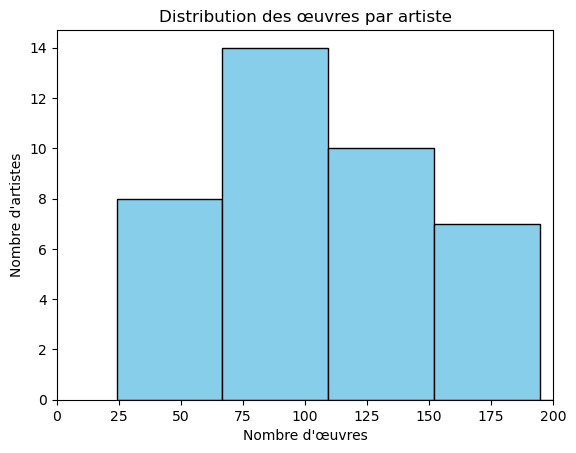

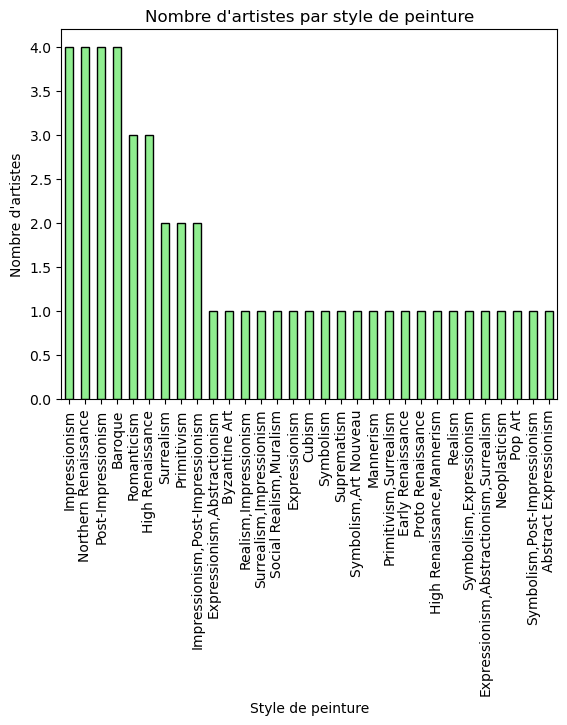

In [8]:
# Analyse descriptive des artistes et des styles
print("Nombre total d'artistes :", artists['name'].nunique())
print("Nombre total de styles :", artists['genre'].nunique())

# Distribution des œuvres par artiste
artists['paintings'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution des œuvres par artiste")
plt.xlabel("Nombre d'œuvres")
plt.ylabel("Nombre d'artistes")
plt.xlim(0, 200)  # Limite de l'axe x
plt.show()

# Distribution des genres de peinture
style_counts = artists['genre'].value_counts()
style_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Nombre d'artistes par style de peinture")
plt.xlabel("Style de peinture")
plt.ylabel("Nombre d'artistes")
plt.xticks(rotation=90)
plt.show()

In [9]:
# Artiste ayant le plus d'œuvres
artist_max = artists.loc[artists['paintings'].idxmax()]
print("Artiste avec le plus d'œuvres :")
print("Nom :", artist_max['name'])
print("Nombre d'œuvres :", artist_max['paintings'])
print("Genre :", artist_max['genre'])

# Artiste ayant le moins d'œuvres
artist_min = artists.loc[artists['paintings'].idxmin()]
print("\nArtiste avec le moins d'œuvres :")
print("Nom :", artist_min['name'])
print("Nombre d'œuvres :", artist_min['paintings'])
print("Genre :", artist_min['genre'])


Artiste avec le plus d'œuvres :
Nom : Vincent van Gogh
Nombre d'œuvres : 877
Genre : Post-Impressionism

Artiste avec le moins d'œuvres :
Nom : Jackson Pollock
Nombre d'œuvres : 24
Genre : Abstract Expressionism


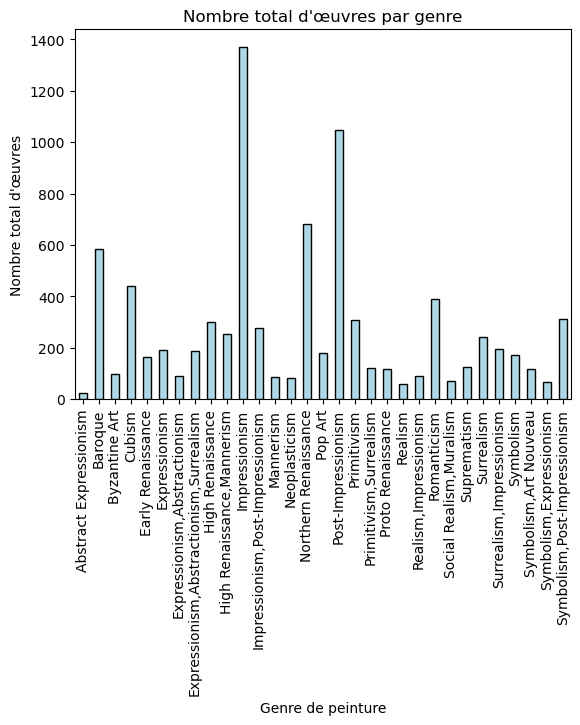

In [10]:
# Calcul du nombre total d'œuvres par genre
genre_paintings = artists.groupby('genre')['paintings'].sum()

# Création de l'histogramme
genre_paintings.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Nombre total d'œuvres par genre")
plt.xlabel("Genre de peinture")
plt.ylabel("Nombre total d'œuvres")
plt.xticks(rotation=90)
plt.show()

On voit que la majorité des artistes ont un nombre d'oeuvre compris entre 100 et 200. Nous allons zoomer sur cette zone, de sorte à ce que nous puissions mieux observer les nombres d'oeuvres par artistes.
Néanmoins, on peut noter qu'un artiste  à plus de 800 oeuvres ( Vincent Van Gogh avec 877 oeuvres) et un artiste a 24 oeuvres (Jackson Pollock).
Cependant, en observant le nombre d'artiste par genre, on remarque que J. Pollock est le seul artiste dans sa catégorie, tandis que la catégorie de V. Van Gogh compte le plus d'artiste. De plus, en observant le nombre d'oeuvre par genre, on observe que le post impressionim compte beaucoup plus d'oeuvres que l'Expressionism. Maintenant que la distrbution des genre et des artistes est bien comprises, nous allons nous mener une analyse des périodes de vie des artistes; 

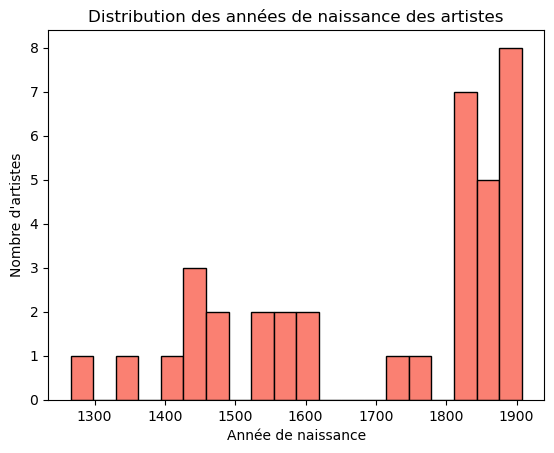

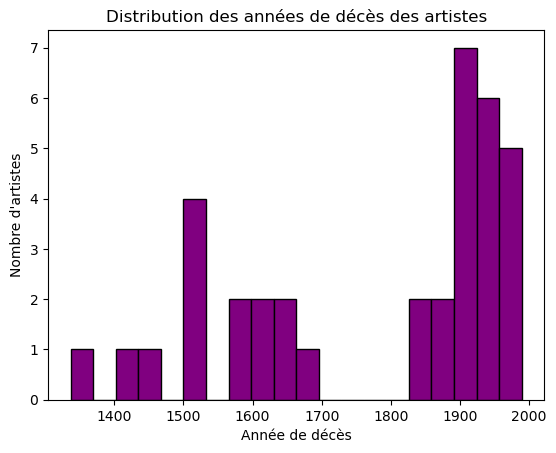

In [11]:
# On sépare la colonne 'year' en deux colonnes : 'birth_year' et 'death_year'
artists[['birth_year', 'death_year']] = artists['years'].str.split('-', expand=True)

# Conversion des nouvelles colonnes en format numérique
artists['birth_year'] = pd.to_numeric(artists['birth_year'], errors='coerce')
artists['death_year'] = pd.to_numeric(artists['death_year'], errors='coerce')

# Histogramme des années de naissance des artistes
artists['birth_year'].dropna().plot(kind='hist', bins=20, color='salmon', edgecolor='black')
plt.title("Distribution des années de naissance des artistes")
plt.xlabel("Année de naissance")
plt.ylabel("Nombre d'artistes")
plt.show()

# Histogramme des années de décès des artistes
artists['death_year'].dropna().plot(kind='hist', bins=20, color='purple', edgecolor='black')
plt.title("Distribution des années de décès des artistes")
plt.xlabel("Année de décès")
plt.ylabel("Nombre d'artistes")
plt.show()

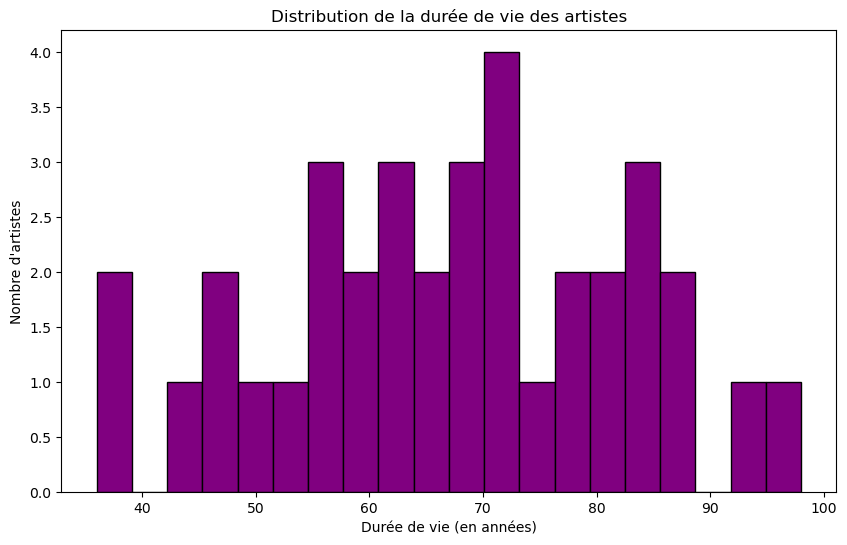

In [12]:
artists['life_duration'] = artists['death_year'] - artists['birth_year']
artists['life_duration'] = artists['life_duration'].dropna()

plt.figure(figsize=(10, 6))
artists['life_duration'].plot(kind='hist', bins=20, color='purple', edgecolor='black')
plt.title('Distribution de la durée de vie des artistes')
plt.xlabel('Durée de vie (en années)')
plt.ylabel('Nombre d\'artistes')
plt.show()

In [13]:
# Identification de l'artiste avec la plus grande durée de vie
longest_lived_artist = artists.loc[artists['life_duration'].idxmax()]
longest_lived_name = longest_lived_artist['name']
longest_lived_paintings = longest_lived_artist['paintings']
longest_lived_duration = longest_lived_artist['life_duration']

# Identification de l'artiste avec la durée de vie la plus courte
shortest_lived_artist = artists.loc[artists['life_duration'].idxmin()]
shortest_lived_name = shortest_lived_artist['name']
shortest_lived_paintings = shortest_lived_artist['paintings']
shortest_lived_duration = shortest_lived_artist['life_duration']

# Affichage des résultats
print(f"Artiste avec la plus grande durée de vie : {longest_lived_name} ({longest_lived_paintings} œuvres, {longest_lived_duration} ans)")
print(f"Artiste avec la durée de vie la plus courte : {shortest_lived_name} ({shortest_lived_paintings} œuvres, {shortest_lived_duration} ans)")


Artiste avec la plus grande durée de vie : Marc Chagall (239 œuvres, 98.0 ans)
Artiste avec la durée de vie la plus courte : Amedeo Modigliani (193 œuvres, 36.0 ans)


In [14]:
correlation = artists['life_duration'].corr(artists['paintings'])
print(f"Corrélation entre durée de vie et nombre d’œuvres : {correlation}")

Corrélation entre durée de vie et nombre d’œuvres : 0.33447442133662464


Nous observons que la majorité des artistes ont émergé à partir de 1800. 

Nombre d'artistes par nationalité :
nationality
French                      13
Italian                      8
Spanish                      5
Dutch                        4
Russian                      4
Flemish                      3
Mexican                      2
American                     2
Belgian                      1
Austrian                     1
Spanish,Greek                1
French,British               1
German                       1
French,Jewish,Belarusian     1
British                      1
Norwegian                    1
German,Swiss                 1
Name: count, dtype: int64


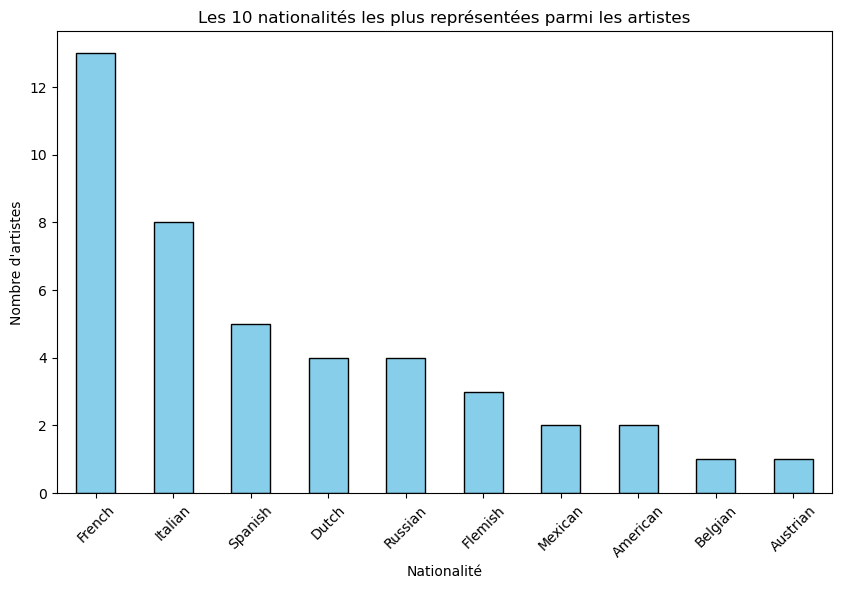

Nationalité la plus représentée : French (13 artistes)
Nationalité la moins représentée : Belgian (1 artiste(s))


In [15]:
# 1. Distribution des nationalités
nationality_counts = artists['nationality'].value_counts()
print("Nombre d'artistes par nationalité :")
print(nationality_counts)

# 2. Visualisation des 10 nationalités les plus représentées
top_nationalities = nationality_counts.head(10)
plt.figure(figsize=(10, 6))
top_nationalities.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Les 10 nationalités les plus représentées parmi les artistes")
plt.xlabel("Nationalité")
plt.ylabel("Nombre d'artistes")
plt.xticks(rotation=45)
plt.show()

# 3. Nationalités les plus et les moins représentées
most_represented_nationality = nationality_counts.idxmax()
least_represented_nationality = nationality_counts.idxmin()

print(f"Nationalité la plus représentée : {most_represented_nationality} ({nationality_counts.max()} artistes)")
print(f"Nationalité la moins représentée : {least_represented_nationality} ({nationality_counts.min()} artiste(s))")


Nombre d'œuvres par pays :
nationality
French                      2120
Dutch                       1360
Spanish                     1099
Italian                     1087
Russian                      484
Flemish                      356
German                       328
French,British               259
French,Jewish,Belarusian     239
American                     205
Belgian                      194
Mexican                      190
German,Swiss                 188
Austrian                     117
Spanish,Greek                 87
Norwegian                     67
British                       66
Name: paintings, dtype: int64


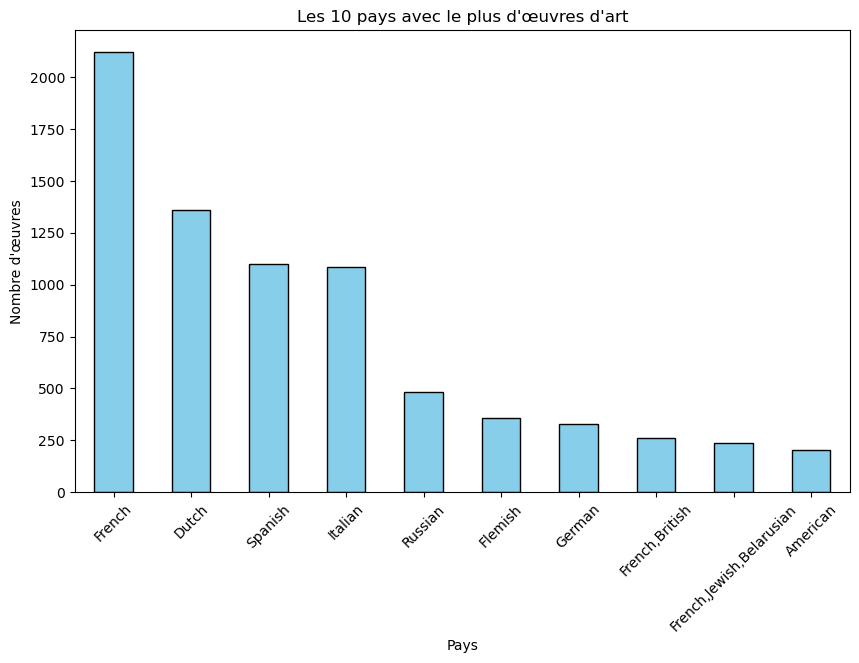

Pays avec le plus d'œuvres : French (2120 œuvres)
Pays avec le moins d'œuvres : British (66 œuvre(s))


In [16]:
# 1. Groupement par nationalité et somme des œuvres par pays
country_paintings = artists.groupby('nationality')['paintings'].sum().sort_values(ascending=False)

print("Nombre d'œuvres par pays :")
print(country_paintings)

# 2. Visualisation des 10 pays les plus représentés en termes d'œuvres
top_countries = country_paintings.head(10)
plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Les 10 pays avec le plus d'œuvres d'art")
plt.xlabel("Pays")
plt.ylabel("Nombre d'œuvres")
plt.xticks(rotation=45)
plt.show()

# 3. Pays avec le plus et le moins d'œuvres
most_paintings_country = country_paintings.idxmax()
least_paintings_country = country_paintings.idxmin()

print(f"Pays avec le plus d'œuvres : {most_paintings_country} ({country_paintings.max()} œuvres)")
print(f"Pays avec le moins d'œuvres : {least_paintings_country} ({country_paintings.min()} œuvre(s))")

Nous observons que la majorité des artistes sont français ou italien, tandis que les artistes les moins nombeux sont orginaires de Belgique, d'Autriche, ...
En outre, nous observons que la France est le pays contenant le plus d'oeuvres, suivi de l'Allemagne. L'Italie arrive en 4ème position, alors qu'elle compte deux fois plus d'artistes que l'Allemagne (4 artistes). Cela nous montre qu'un nombre plus élevé d'artiste dans un pays n'implique pas forcément un plus grand nombre d'oeuvres produites par ces artistes.

## Global params

In [17]:
BATCH_SIZE = 32
EPOCHS = 3
CHANNELS = 3

# For HQ images only
IMAGE_HQ_SIZE = 224
IMAGE_LQ_SIZE = 64
MEAN_HQ = [0.485, 0.456, 0.406]
STD_HQ = [0.229, 0.224, 0.225]
TRANSFORM_HQ = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),  # Interpolate
    #transforms.Pad((32, 32, 32, 32)),  # Padding
    transforms.CenterCrop(224),  # Center
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN_HQ, std=STD_HQ)
])



def load_image_as_rgb_matrices(image_name):    
    img = Image.open(images_lq_path + image_name)
    img = img.resize((IMAGE_LQ_SIZE, IMAGE_LQ_SIZE))  
    img = img.convert('RGB')
    return np.array(img)

## Creating LQ images loaders

In [18]:
# Loading LQ images
images_lq_path = data_path + "images_lq/"
images_filename = os.listdir(images_lq_path)

list_name = []

for filename in images_filename:
    parts = filename.split('_')
    if len(parts) > 2:
        name_surname = f"{parts[0]} {parts[1]}"
    elif len(parts) == 2:  # "Name_xxx" format
        name_surname = parts[0]  # Only Name
    list_name.append(name_surname)

In [19]:
if len(images_filename) == len(list_name):
    total_lq_df = pd.DataFrame({
        'filename': images_filename,  # Liste des noms de fichiers
        'artist': list_name,          # Liste des artistes pour chaque peinture
    })
    print("DataFrame created successfully!")
else:
    print("Error: The lists have different lengths.")

DataFrame created successfully!


In [20]:
from collections import Counter

# Compter les occurrences des artistes
artist_counts_lq = Counter(total_lq_df['artist'])

# Afficher les occurrences de chaque artiste
print("Occurrences de chaque artiste dans le dataset LQ :")
for artist, count in artist_counts_lq.items():
    print(f"{artist}: {count} occurrences")


Occurrences de chaque artiste dans le dataset LQ :
Albrecht Dürer: 328 occurrences
Alfred Sisley: 259 occurrences
Amedeo Modigliani: 193 occurrences
Andrei Rublev: 99 occurrences
Andy Warhol: 181 occurrences
Camille Pissarro: 91 occurrences
Caravaggio: 55 occurrences
Claude Monet: 73 occurrences
Diego Rivera: 70 occurrences
Diego Velazquez: 37 occurrences
Edgar Degas: 702 occurrences
Edouard Manet: 90 occurrences
Edvard Munch: 67 occurrences
El Greco: 87 occurrences
Eugene Delacroix: 31 occurrences
Francisco Goya: 291 occurrences
Frida Kahlo: 120 occurrences
Georges Seurat: 43 occurrences
Giotto di: 119 occurrences
Gustave Courbet: 59 occurrences
Gustav Klimt: 117 occurrences
Henri de: 81 occurrences
Henri Matisse: 186 occurrences
Henri Rousseau: 70 occurrences
Hieronymus Bosch: 137 occurrences
Jackson Pollock: 24 occurrences
Jan van: 81 occurrences
Joan Miro: 102 occurrences
Kazimir Malevich: 126 occurrences
Leonardo da: 143 occurrences
Marc Chagall: 239 occurrences
Michelangelo: 49 o

In [21]:
from collections import Counter

# Calculer le nombre d'artistes 
num_artists_lq = len(artist_counts_lq)
print("Nombre d'artistes :",num_artists_lq)


Nombre d'artistes : 50


In [22]:
from collections import Counter

# Compter les occurrences des artistes dans les images LQ
artist_counts_lq = Counter(total_lq_df['artist'])

# Filtrer les artistes ayant plus de 85 occurrences
artists_with_more_than_85_lq = {
    artist: count for artist, count in artist_counts_lq.items() if count > 85
}

# Liste des artistes à garder
artists_list_lq = list(artists_with_more_than_85_lq.keys())

# Afficher les artistes sélectionnés
print("Artistes avec plus de 85 occurrences dans les images LQ :")
for artist, count in artists_with_more_than_85_lq.items():
    print(f"{artist}: {count} occurrences")


Artistes avec plus de 85 occurrences dans les images LQ :
Albrecht Dürer: 328 occurrences
Alfred Sisley: 259 occurrences
Amedeo Modigliani: 193 occurrences
Andrei Rublev: 99 occurrences
Andy Warhol: 181 occurrences
Camille Pissarro: 91 occurrences
Edgar Degas: 702 occurrences
Edouard Manet: 90 occurrences
El Greco: 87 occurrences
Francisco Goya: 291 occurrences
Frida Kahlo: 120 occurrences
Giotto di: 119 occurrences
Gustav Klimt: 117 occurrences
Henri Matisse: 186 occurrences
Hieronymus Bosch: 137 occurrences
Joan Miro: 102 occurrences
Kazimir Malevich: 126 occurrences
Leonardo da: 143 occurrences
Marc Chagall: 239 occurrences
Mikhail Vrubel: 171 occurrences
Pablo Picasso: 439 occurrences
Paul Gauguin: 311 occurrences
Paul Klee: 188 occurrences
Peter Paul: 141 occurrences
Pierre-Auguste Renoir: 336 occurrences
Pieter Bruegel: 134 occurrences
Raphael: 109 occurrences
Rembrandt: 262 occurrences
Rene Magritte: 194 occurrences
Salvador Dali: 139 occurrences
Sandro Botticelli: 164 occurrenc

In [23]:
from collections import Counter

# Calculer le nombre d'artistes 
num_artists_lq_more_85 = len(artists_with_more_than_85_lq)
print("Nombre d'artistes avec plus de 85 occurences :", num_artists_lq_more_85)


Nombre d'artistes avec plus de 85 occurences : 34


In [24]:
# Filtrer les données LQ pour ne garder que les artistes sélectionnés
total_lq_filtered = total_lq_df[total_lq_df['artist'].isin(artists_list_lq)].copy()

# Liste des fichiers d'images filtrés
images_filename_filtered = total_lq_filtered['filename'].tolist()

# Mettre à jour le nombre d'images après filtrage
DATASET_LQ_SIZE = len(images_filename_filtered)
print(f"Nombre total d'images après filtrage : {DATASET_LQ_SIZE}")


Nombre total d'images après filtrage : 7418


In [25]:
# Initialiser un tableau pour les images filtrées
x_filtered = np.zeros((DATASET_LQ_SIZE, IMAGE_LQ_SIZE, IMAGE_LQ_SIZE, CHANNELS))

for i, filename in enumerate(images_filename_filtered):
    x_filtered[i] = load_image_as_rgb_matrices(filename)
    
# Mettre à jour les classes après filtrage
classes_filtered = np.array(list(set(total_lq_filtered['artist'])))
classes_as_int_filtered = np.array([
    np.where(classes_filtered == artist)[0][0] for artist in total_lq_filtered['artist']
])
# Diviser les données filtrées
x_train, x_test_val, y_train, y_test_val = train_test_split(
    np.transpose(x_filtered, (0, 3, 1, 2)),  
    classes_as_int_filtered, 
    test_size=0.2, 
    random_state=42
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test_val, 
    y_test_val, 
    test_size=0.5, 
    random_state=42
)

# Normaliser les images
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0


In [26]:
# Convertir en tenseurs
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Créer les datasets et DataLoaders
train_dataset_lq = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset_lq = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset_lq = TensorDataset(x_test_tensor, y_test_tensor)

train_loader_lq = DataLoader(train_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_lq = DataLoader(val_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_lq = DataLoader(test_dataset_lq, batch_size=1, shuffle=False)

# Afficher les tailles des ensembles
print(f"Train dataset size: {len(train_dataset_lq)}")
print(f"Validation dataset size: {len(val_dataset_lq)}")
print(f"Test dataset size: {len(test_dataset_lq)}")


Train dataset size: 5934
Validation dataset size: 742
Test dataset size: 742


In [27]:
# Chemin des images LQ
images_lq_path = data_path + "images_lq/"
images_filename = os.listdir(images_lq_path)

# Extraire les noms des artistes depuis les noms des fichiers
list_name = []
for filename in images_filename:
    parts = filename.split('_')
    if len(parts) > 2:
        name_surname = f"{parts[0]} {parts[1]}"
    elif len(parts) == 2:  # "Name_xxx" format
        name_surname = parts[0]  # Only Name
    list_name.append(name_surname)

# Création du DataFrame des métadonnées
if len(images_filename) == len(list_name):
    total_lq_df = pd.DataFrame({
        'filename': images_filename,  # Liste des noms de fichiers
        'artist': list_name,          # Liste des artistes pour chaque peinture
    })
    print("DataFrame created successfully!")
else:
    print("Error: The lists have different lengths.")

# Comptage des occurrences de chaque artiste
artist_counts_lq = Counter(total_lq_df['artist'])

# Filtrer les artistes avec plus de 85 œuvres
selected_artists = [artist for artist, count in artist_counts_lq.items() if count > 85]

# Filtrer le DataFrame pour ne conserver que ces artistes
filtered_lq_df = total_lq_df[total_lq_df['artist'].isin(selected_artists)].copy()

# Afficher les artistes et leur nombre d'œuvres
print("\nArtistes avec plus de 85 œuvres :")
artist_counts_filtered = Counter(filtered_lq_df['artist'])
for artist, count in artist_counts_filtered.items():
    print(f"{artist}: {count} œuvres")

# Enregistrer les occurrences des artistes filtrés dans un fichier CSV (facultatif)
artist_counts_filtered_df = pd.DataFrame.from_dict(
    artist_counts_filtered, orient='index', columns=['Occurrences']
).sort_values(by='Occurrences', ascending=False)
artist_counts_filtered_df.to_csv("filtered_artist_occurrences_lq.csv", index=True)

# Chargement des images filtrées
IMAGE_LQ_SIZE = 64
DATASET_LQ_SIZE = len(filtered_lq_df)
CHANNELS = 3


x_filtered = np.zeros((DATASET_LQ_SIZE, IMAGE_LQ_SIZE, IMAGE_LQ_SIZE, CHANNELS))
for i, filename in enumerate(filtered_lq_df['filename']):
    x_filtered[i] = load_image_as_rgb_matrices(filename)

# Mettre à jour les classes
classes_filtered = np.array(list(set(filtered_lq_df['artist'])))
classes_as_int_filtered = np.array([
    np.where(classes_filtered == artist)[0][0] for artist in filtered_lq_df['artist']
])

# Diviser les données en ensembles d'entraînement, validation et test
x_train, x_test_val, y_train, y_test_val = train_test_split(
    np.transpose(x_filtered, (0, 3, 1, 2)),  
    classes_as_int_filtered, 
    test_size=0.2, 
    random_state=42
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test_val, 
    y_test_val, 
    test_size=0.5, 
    random_state=42
)

# Normaliser les images
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

# Convertir les données en tenseurs PyTorch
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Créer les DataLoaders
train_dataset_lq = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset_lq = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset_lq = TensorDataset(x_test_tensor, y_test_tensor)

train_loader_lq = DataLoader(train_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_lq = DataLoader(val_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_lq = DataLoader(test_dataset_lq, batch_size=1, shuffle=False)

# Afficher les tailles des ensembles
print(f"Train dataset size: {len(train_dataset_lq)}")
print(f"Validation dataset size: {len(val_dataset_lq)}")
print(f"Test dataset size: {len(test_dataset_lq)}")


DataFrame created successfully!

Artistes avec plus de 85 œuvres :
Albrecht Dürer: 328 œuvres
Alfred Sisley: 259 œuvres
Amedeo Modigliani: 193 œuvres
Andrei Rublev: 99 œuvres
Andy Warhol: 181 œuvres
Camille Pissarro: 91 œuvres
Edgar Degas: 702 œuvres
Edouard Manet: 90 œuvres
El Greco: 87 œuvres
Francisco Goya: 291 œuvres
Frida Kahlo: 120 œuvres
Giotto di: 119 œuvres
Gustav Klimt: 117 œuvres
Henri Matisse: 186 œuvres
Hieronymus Bosch: 137 œuvres
Joan Miro: 102 œuvres
Kazimir Malevich: 126 œuvres
Leonardo da: 143 œuvres
Marc Chagall: 239 œuvres
Mikhail Vrubel: 171 œuvres
Pablo Picasso: 439 œuvres
Paul Gauguin: 311 œuvres
Paul Klee: 188 œuvres
Peter Paul: 141 œuvres
Pierre-Auguste Renoir: 336 œuvres
Pieter Bruegel: 134 œuvres
Raphael: 109 œuvres
Rembrandt: 262 œuvres
Rene Magritte: 194 œuvres
Salvador Dali: 139 œuvres
Sandro Botticelli: 164 œuvres
Titian: 255 œuvres
Vasiliy Kandinskiy: 88 œuvres
Vincent van: 877 œuvres
Train dataset size: 5934
Validation dataset size: 742
Test dataset siz

In [28]:
# Prints df if previously created
total_lq_df.head()

,filename,artist
0,Albrecht_Dürer_1.jpg,Albrecht Dürer
1,Albrecht_Dürer_10.jpg,Albrecht Dürer
2,Albrecht_Dürer_100.jpg,Albrecht Dürer
3,Albrecht_Dürer_101.jpg,Albrecht Dürer
4,Albrecht_Dürer_102.jpg,Albrecht Dürer


In [29]:
IMAGE_LQ_SIZE = 64
DATASET_LQ_SIZE = len(images_filename)
CHANNELS = 3

x = np.zeros((DATASET_LQ_SIZE, IMAGE_LQ_SIZE, IMAGE_LQ_SIZE, CHANNELS))
for i in range(DATASET_LQ_SIZE):
    x[i] = load_image_as_rgb_matrices(images_filename[i])

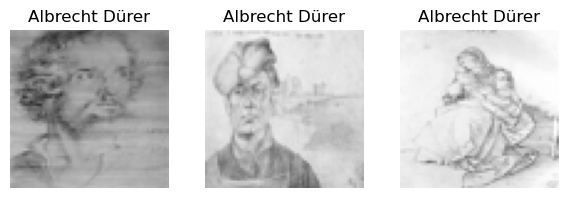

In [30]:
# Few plots
number_of_plots = 3
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(number_of_plots * 2, 2))

for i in range(number_of_plots):
    axes[i].imshow(x[i*100]/255.0)
    axes[i].axis('off')
    axes[i].set_title(f"{list_name[i*100]}")
    
plt.tight_layout()
plt.show()

In [31]:
# Filtrer les données LQ pour ne garder que les artistes sélectionnés
total_lq_filtered = total_lq_df[total_lq_df['artist'].isin(artists_list)].copy()
images_filename_filtered = total_lq_filtered['filename'].tolist()

# Charger les images filtrées
DATASET_LQ_SIZE = len(images_filename_filtered)
x_filtered = np.zeros((DATASET_LQ_SIZE, IMAGE_LQ_SIZE, IMAGE_LQ_SIZE, CHANNELS))

for i, filename in enumerate(images_filename_filtered):
    x_filtered[i] = load_image_as_rgb_matrices(filename)

# Mettre à jour les classes
classes_filtered = np.array(list(set(total_lq_filtered['artist'])))
classes_as_int_filtered = np.array([
    np.where(classes_filtered == artist)[0][0] for artist in total_lq_filtered['artist']
])

# Diviser les données en ensembles d'entraînement, validation et test
x_train, x_test_val, y_train, y_test_val = train_test_split(
    np.transpose(x_filtered, (0, 3, 1, 2)),  
    classes_as_int_filtered, 
    test_size=0.2, 
    random_state=42
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test_val, 
    y_test_val, 
    test_size=0.5, 
    random_state=42
)


KeyboardInterrupt: 

In [32]:
# Normalize images
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset_lq = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset_lq = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset_lq = TensorDataset(x_test_tensor, y_test_tensor)

train_loader_lq = DataLoader(train_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_lq = DataLoader(val_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_lq = DataLoader(test_dataset_lq, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_lq)}")
print(f"Validation dataset size: {len(val_dataset_lq)}")
print(f"Test dataset size: {len(test_dataset_lq)}")

Train dataset size: 4940
Validation dataset size: 618
Test dataset size: 617


In [33]:
# All the artists
classes = np.array(list(set(total_lq_df['artist'])))
classes_as_int = np.array([np.where(classes == artist)[0][0] for artist in total_lq_df['artist']])

x_train, x_test_val, y_train, y_test_val = train_test_split(
    np.transpose(x, (0, 3, 1, 2)),  classes_as_int, test_size=0.2, random_state=42
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test_val, y_test_val, test_size=0.5, random_state=42
)

# Normalize images
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset_lq = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset_lq = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset_lq = TensorDataset(x_test_tensor, y_test_tensor)

train_loader_lq = DataLoader(train_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_lq = DataLoader(val_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_lq = DataLoader(test_dataset_lq, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_lq)}")
print(f"Validation dataset size: {len(val_dataset_lq)}")
print(f"Test dataset size: {len(test_dataset_lq)}")

Train dataset size: 6684
Validation dataset size: 836
Test dataset size: 835


## Creating HQ images loaders

In [18]:
# Loading HQ images
gc = "./art-challenge/images_hq"
dataset_hq = datasets.ImageFolder(root=gc, transform=TRANSFORM_HQ)
DATASET_HQ_SIZE = len(dataset_hq)
CLASS_TO_IDX_HQ = dataset_hq.class_to_idx
IDX_TO_CLASS_HQ = {idx: name for name, idx in CLASS_TO_IDX_HQ.items()}

In [19]:
# Filtrer les artistes ayant plus de 85 œuvres
artists_filtered = artists.loc[artists['paintings'] > 85, 'name']

# Liste des artistes à garder
artists_list = artists_filtered.tolist()

# Affichage de la liste des artistes ayant plus de 85 œuvres
print("Artistes avec plus de 85 œuvres :")
for artist in artists_list:
    print(artist)


Artistes avec plus de 85 œuvres :
Amedeo Modigliani
Vasiliy Kandinskiy
Rene Magritte
Salvador Dali
Edouard Manet
Andrei Rublev
Vincent van Gogh
Gustav Klimt
Hieronymus Bosch
Kazimir Malevich
Mikhail Vrubel
Pablo Picasso
Peter Paul Rubens
Pierre-Auguste Renoir
Francisco Goya
Frida Kahlo
El Greco
Albrecht Dürer
Alfred Sisley
Pieter Bruegel
Marc Chagall
Giotto di Bondone
Sandro Botticelli
Leonardo da Vinci
Diego Velazquez
Henri Matisse
Edgar Degas
Rembrandt
Titian
Camille Pissarro
Paul Klee
Joan Miro
Andy Warhol
Paul Gauguin
Raphael


In [20]:
# Liste des artistes
list_of_artists_hq = list(CLASS_TO_IDX_HQ.keys())

# Affichage des artistes
print("Liste des artistes dans le dataset HQ:")
for artist in list_of_artists_hq:
    print(artist)


Liste des artistes dans le dataset HQ:
Albrecht_Dürer
Alfred_Sisley
Amedeo_Modigliani
Andrei_Rublev
Andy_Warhol
Camille_Pissarro
Caravaggio
Claude_Monet
Diego_Rivera
Diego_Velazquez
Edgar_Degas
Edouard_Manet
Edvard_Munch
El_Greco
Eugene_Delacroix
Francisco_Goya
Frida_Kahlo
Georges_Seurat
Giotto_di_Bondone
Gustav_Klimt
Gustave_Courbet
Henri_Matisse
Henri_Rousseau
Henri_de_Toulouse-Lautrec
Hieronymus_Bosch
Jackson_Pollock
Jan_van_Eyck
Joan_Miro
Kazimir_Malevich
Leonardo_da_Vinci
Marc_Chagall
Michelangelo
Mikhail_Vrubel
Pablo_Picasso
Paul_Cezanne
Paul_Gauguin
Paul_Klee
Peter_Paul_Rubens
Pierre-Auguste_Renoir
Piet_Mondrian
Pieter_Bruegel
Raphael
Rembrandt
Rene_Magritte
Salvador_Dali
Sandro_Botticelli
Titian
Vasiliy_Kandinskiy
Vincent_van_Gogh
William_Turner


In [35]:
# Affichage du nombre d'oeuvres pour chaque artiste
print("Nombre d'œuvres pour chaque artiste dans le dataset HQ :")
for artist in list_of_artists_hq:
    if artist in artists['name'].values:  # Vérifier si l'artiste existe dans le DataFrame
        num_paintings = artists.loc[artists['name'] == artist, 'paintings'].values[0]
        print(f"{artist}: {num_paintings} œuvres")
    else:
        print(f"{artist}: Nombre d'œuvres inconnu")


Nombre d'œuvres pour chaque artiste dans le dataset HQ :
Albrecht_Dürer: Nombre d'œuvres inconnu
Alfred_Sisley: Nombre d'œuvres inconnu
Amedeo_Modigliani: Nombre d'œuvres inconnu
Andrei_Rublev: Nombre d'œuvres inconnu
Andy_Warhol: Nombre d'œuvres inconnu
Camille_Pissarro: Nombre d'œuvres inconnu
Caravaggio: 55 œuvres
Claude_Monet: Nombre d'œuvres inconnu
Diego_Rivera: Nombre d'œuvres inconnu
Diego_Velazquez: Nombre d'œuvres inconnu
Edgar_Degas: Nombre d'œuvres inconnu
Edouard_Manet: Nombre d'œuvres inconnu
Edvard_Munch: Nombre d'œuvres inconnu
El_Greco: Nombre d'œuvres inconnu
Eugene_Delacroix: Nombre d'œuvres inconnu
Francisco_Goya: Nombre d'œuvres inconnu
Frida_Kahlo: Nombre d'œuvres inconnu
Georges_Seurat: Nombre d'œuvres inconnu
Giotto_di_Bondone: Nombre d'œuvres inconnu
Gustav_Klimt: Nombre d'œuvres inconnu
Gustave_Courbet: Nombre d'œuvres inconnu
Henri_Matisse: Nombre d'œuvres inconnu
Henri_Rousseau: Nombre d'œuvres inconnu
Henri_de_Toulouse-Lautrec: Nombre d'œuvres inconnu
Hiero

In [36]:
from collections import Counter

# Initialisation du compteur
artist_counts = Counter()

# Parcours du dataset et comptage des artistes
for _, label in dataset_hq:
    artist = IDX_TO_CLASS_HQ[label]  # Utilise le label pour obtenir le nom de l'artiste
    artist_counts[artist] += 1

# Affichage des résultats
print("Nombre d'occurrences de chaque artiste dans le dataset HQ :")
for artist, count in artist_counts.items():
    print(f"{artist}: {count} occurrences")


KeyboardInterrupt: 

In [55]:
from collections import Counter

# Calculer le nombre d'artistes 
num_artists = len(artist_counts)
num_artists


50

In [19]:
from collections import Counter

# Initialisation du compteur
artist_counts = Counter()

# Parcours du dataset et comptage des artistes
for _, label in dataset_hq:
    artist = IDX_TO_CLASS_HQ[label]  # Utilise le label pour obtenir le nom de l'artiste
    artist_counts[artist] += 1

# Filtrer les artistes ayant plus de 85 occurrences
artists_with_more_than_85 = {artist: count for artist, count in artist_counts.items() if count > 85}

# Affichage des artistes avec plus de 85 occurrences
print("Artistes ayant plus de 85 occurrences dans le dataset HQ :")
for artist, count in artists_with_more_than_85.items():
    print(f"{artist}: {count} occurrences")


NameError: name 'dataset_hq' is not defined

In [57]:
from collections import Counter

# Calculer le nombre d'artistes ayant plus de 85 occurrences
num_artists_more_than_85 = len(artists_with_more_than_85)
num_artists_more_than_85


35

En fait, certains artistes ( qui ont des oeuvres de hautes qualitées) ne sont pas dans le dataframe artists, j'ai donc compté le nombre d'occurence de chacun des artistes, afin de savoir combien chacun des artistes avaient d'oeuvres. J'ai ensuite, conservé uniquement les artistes ayant plus de 85 occurences ( chaque occurence représentant une oeuvre)

Il y a en tout 50 artistes dont 35 ayant un nombre d'oeuvres supérieur à 85.

Pour le training sur HQ (en gardant uniquement les artistes avec plus de 85 oeuvres) c'est cette cellule qu'il faut run.

In [21]:
from collections import Counter
from torch.utils.data import DataLoader, random_split
from torchvision import datasets

# Charger le dataset HQ
gc = "./art-challenge/images_hq"
dataset_hq = datasets.ImageFolder(root=gc, transform=TRANSFORM_HQ)
DATASET_HQ_SIZE = len(dataset_hq)
CLASS_TO_IDX_HQ = dataset_hq.class_to_idx
IDX_TO_CLASS_HQ = {idx: name for name, idx in CLASS_TO_IDX_HQ.items()}

# Comptage des occurrences pour chaque artiste
artist_counts = Counter()
for _, label in dataset_hq:
    artist = IDX_TO_CLASS_HQ[label]
    artist_counts[artist] += 1

# Filtrer les artistes ayant plus de 85 occurrences
artists_with_more_than_85 = {artist: count for artist, count in artist_counts.items() if count > 85}
print("Artistes avec plus de 85 occurrences :")
for artist, count in artists_with_more_than_85.items():
    print(f"{artist}: {count} occurrences")

# Réindexer les classes en fonction des artistes filtrés
hq_class_to_new_idx = {artist: idx for idx, artist in enumerate(artists_with_more_than_85)}
hq_idx_to_class = {idx: artist for artist, idx in hq_class_to_new_idx.items()}

# Filtrer les indices des artistes sélectionnés
hq_indices = [CLASS_TO_IDX_HQ[artist] for artist in artists_with_more_than_85 if artist in CLASS_TO_IDX_HQ]

# Filtrer les données du dataset HQ pour ne garder que les indices valides
filtered_hq_dataset = [data for data in dataset_hq if data[1] in hq_indices]

# Mise à jour des labels du dataset filtré pour correspondre aux nouveaux indices
filtered_hq_dataset = [(data[0], hq_class_to_new_idx[IDX_TO_CLASS_HQ[data[1]]]) for data in filtered_hq_dataset]

# Création des ensembles de données filtrés
train_size = int(0.8 * len(filtered_hq_dataset))
val_size = int(0.1 * len(filtered_hq_dataset))
test_size = len(filtered_hq_dataset) - train_size - val_size

train_dataset_hq, val_dataset_hq, test_dataset_hq = random_split(
    filtered_hq_dataset, [train_size, val_size, test_size]
)

# Chargement des ensembles de données dans les DataLoaders
train_loader_hq = DataLoader(train_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_hq = DataLoader(val_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_hq = DataLoader(test_dataset_hq, batch_size=1, shuffle=False)

# Affichage des tailles des datasets
print(f"Train dataset size: {len(train_dataset_hq)}")
print(f"Validation dataset size: {len(val_dataset_hq)}")
print(f"Test dataset size: {len(test_dataset_hq)}")


Artistes avec plus de 85 occurrences :
Albrecht_Dürer: 328 occurrences
Alfred_Sisley: 259 occurrences
Amedeo_Modigliani: 193 occurrences
Andrei_Rublev: 99 occurrences
Andy_Warhol: 181 occurrences
Camille_Pissarro: 91 occurrences
Diego_Velazquez: 128 occurrences
Edgar_Degas: 702 occurrences
Edouard_Manet: 90 occurrences
El_Greco: 87 occurrences
Francisco_Goya: 291 occurrences
Frida_Kahlo: 120 occurrences
Giotto_di_Bondone: 119 occurrences
Gustav_Klimt: 117 occurrences
Henri_Matisse: 186 occurrences
Hieronymus_Bosch: 137 occurrences
Joan_Miro: 102 occurrences
Kazimir_Malevich: 126 occurrences
Leonardo_da_Vinci: 143 occurrences
Marc_Chagall: 239 occurrences
Mikhail_Vrubel: 171 occurrences
Pablo_Picasso: 439 occurrences
Paul_Gauguin: 311 occurrences
Paul_Klee: 188 occurrences
Peter_Paul_Rubens: 141 occurrences
Pierre-Auguste_Renoir: 336 occurrences
Pieter_Bruegel: 134 occurrences
Raphael: 109 occurrences
Rembrandt: 262 occurrences
Rene_Magritte: 194 occurrences
Salvador_Dali: 139 occurrenc

In [22]:
print(f"Train dataset size: {len(train_dataset_hq)}")
print(f"Validation dataset size: {len(val_dataset_hq)}")
print(f"Test dataset size: {len(test_dataset_hq)}")

Train dataset size: 6036
Validation dataset size: 754
Test dataset size: 756


On passe donc de : 

Train dataset size: 6756

Validation dataset size: 844

Test dataset size: 846

à

Train dataset size: 6036

Validation dataset size: 754

Test dataset size: 756

In [39]:
train_size = int(0.8 * DATASET_HQ_SIZE)  # 70% 
val_size = int(0.1 * DATASET_HQ_SIZE)   # 15% 
test_size = DATASET_HQ_SIZE - train_size - val_size

train_dataset_hq, val_dataset_hq, test_dataset_hq = random_split(dataset_hq, [train_size, val_size, test_size])

train_loader_hq = DataLoader(train_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_hq = DataLoader(val_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_hq = DataLoader(test_dataset_hq, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_hq)}")
print(f"Validation dataset size: {len(val_dataset_hq)}")
print(f"Test dataset size: {len(test_dataset_hq)}")

Train dataset size: 6756
Validation dataset size: 844
Test dataset size: 846


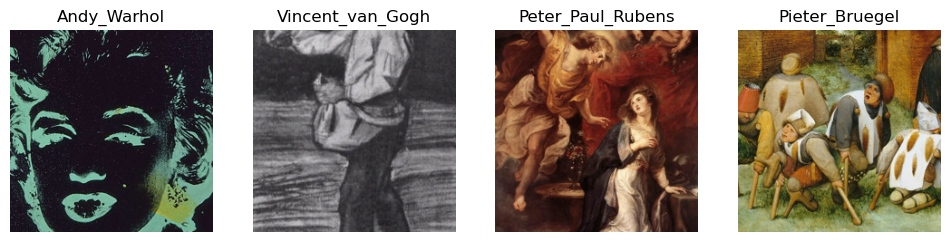

In [39]:
def show_images(images, labels, nb_plots = 4):
    if not nb_plots <= images.shape[0]:
        return
        
    images = images.permute(0, 2, 3, 1)  # From (batch, C, H, W) to (batch, H, W, C)
    
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    images = images * std + mean
    
    plt.figure(figsize=(12, 8))
    for i in range(nb_plots):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')
        plt.title(f'{IDX_TO_CLASS_HQ[labels[i].item()]}')
    plt.show()

# Print few training images
images, labels = next(iter(train_loader_hq))
show_images(images, labels)

## Focal Loss

Comme observé durant l'analyse descriptive, les artistes n'ont pas tous le même nombre d'oeuvres. En effet, certains artistes ont une vingtaine d'oeuvres tandis que d'autres en ont plus de 800. Cela peut s'avérer être assez problématique dans le calcul de la loss, de ce fait, nous allons utiliser une focal loss. Cette loss permet de traiter les déséquilibre dans les "classes", elle est une modification de la cross entropy en ajoutant un terme de pondération. 
Cette perte permettra d'éviter que certains artistes avec beaucoup d'oeuvres contribuent trop à la loss. 

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Poids par classe (peut être un tensor)
        self.gamma = gamma  # Facteur de focalisation
        self.reduction = reduction  # mean, sum ou none

    def forward(self, inputs, targets):
        # Appliquer un softmax pour convertir les logits en probabilités
        probs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.size(1)).float()
        
        # Extraire les probabilités des classes cibles
        pt = (probs * targets_one_hot).sum(dim=1)
        
        # Calculer la focal loss
        focal_loss = -((1 - pt) ** self.gamma) * torch.log(pt)
        
        # Appliquer les poids de classe si fournis
        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            focal_loss *= at
        
        # Réduire la perte si nécessaire
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [41]:
# Extraire les informations sur les artistes et leurs œuvres
artist_counts = artists['paintings'].values
total_paintings = artist_counts.sum()

# Inverser la proportion pour accorder plus de poids aux artistes avec peu d'œuvres
weights = total_paintings / (len(artist_counts) * artist_counts)
alpha = torch.tensor(weights, dtype=torch.float32)


In [42]:
from collections import Counter
import numpy as np
import torch

# Fréquence des classes dans le dataset
class_counts = Counter(dataset_hq.targets)  # `targets` contient les labels des artistes
total_samples = sum(class_counts.values())

# Calcul des poids inversés pour chaque classe
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
class_weights = torch.tensor([class_weights[cls] for cls in sorted(class_counts.keys())], dtype=torch.float32).to(DEVICE)


In [43]:
import torch
import torch.nn as nn

class FocalLossWithWeights(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, class_weights=None):
        super(FocalLossWithWeights, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights  # Poids spécifiques aux classes

    def forward(self, inputs, targets):
        # Appliquer softmax pour obtenir les probabilités
        probs = torch.softmax(inputs, dim=1)
        probs = probs.gather(1, targets.view(-1, 1)).squeeze()

        # Focal Weighting
        focal_weight = (1 - probs) ** self.gamma

        # Log-loss avec les poids des classes
        if self.class_weights is not None:
            weights = self.class_weights[targets]
            loss = -self.alpha * weights * focal_weight * torch.log(probs + 1e-8)
        else:
            loss = -self.alpha * focal_weight * torch.log(probs + 1e-8) # +1e-8 pour éviter d'avoir 0

        return loss.mean()


## Training and Optimization Part

In [23]:
#NUM_CLASSES = len(dataset_hq.classes) # Same value for lQ dataset
NUM_CLASSES = len(artists_with_more_than_85)
DROPOUT_RATE = 0.4
MODEL_PATH = "cnn_weights.pth"

def get_model(name='resnet18', weights='IMAGENET1K_V1', verbose=False):
    model = getattr(models, name)(weights=weights)
    model.fc = nn.Sequential(
        nn.Dropout(p=DROPOUT_RATE),                  
        nn.Linear(model.fc.in_features, NUM_CLASSES)
    ) 

    if verbose:
        trainable_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable_params}')
        
    return model

In [24]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS, save_model=False, model_path=MODEL_PATH):
    # Training of the model
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        total_train_samples = 0
        correct_train = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            # FB
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # BW
            loss.backward()
            optimizer.step()
            
            # Do not need to apply softmax manually -> this order will be the same
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()

            train_loss += loss.item()
            total_train_samples += images.size(0)
        
        train_loss = train_loss / total_train_samples
        train_accuracy = correct_train / total_train_samples

        # Validation
        model.eval()
        val_loss = 0.0
        total_val_samples = 0
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                total_val_samples += images.size(0)
                
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
        
        val_loss = val_loss / total_val_samples
        val_accuracy = correct_val / total_val_samples
        
        # Train accuracy could be used to check if the network learns something
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if save_model:
        torch.save(model.state_dict(), model_path)    

In [23]:
def test(test_loader, model_path=MODEL_PATH):
    model = get_model(weights=None)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model = model.to(DEVICE)

    # Validation
    model.eval()
    test_loss = 0.0
    total_test_samples = 0
    correct_test = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
                
            outputs = model(images)
            loss = criterion(outputs, labels)
                
            test_loss += loss.item()
            total_test_samples += images.size(0)
                
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
        
        test_loss = test_loss / total_test_samples
        test_accuracy = correct_test / total_test_samples

        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy

In [26]:
# Here we use Optuna to optimize the best hyper-params
# Long time execution...
# See https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py
def objective(trial):
    # Define the model
    model = get_model()
    model = model.to(DEVICE)

    # The different parameters we're trying to improve
    fc_lr = trial.suggest_float("fc_lr", 1e-4, 1e-2, log=True)  
    base_lr = trial.suggest_float("base_lr", 1e-6, 1e-4, log=True)

    base_params = [p for name, p in model.named_parameters() if "fc" not in name]    
    # Init optimizer
    optimizer = optim.Adam([
        {'params': model.fc.parameters(), 'lr': fc_lr},      # LR for fully connected layer
        {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
    ])

    # Loss
    criterion = nn.CrossEntropyLoss(reduction='sum')
    #criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')
    
    train(model, criterion, optimizer, train_loader_hq, val_loader_hq)
    
    trial.report(val_accuracy, epoch)

    # Handle pruning based on the intermediate value.
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return val_accuracy

In [27]:
# Default sampler used: https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-12-06 11:16:22,548] A new study created in memory with name: no-name-42cdc2dd-9363-4b04-b9db-7ddfe20e624b
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.65it/s]


Epoch 1/3, Train Loss: 2.2156, Train Accuracy: 0.3998, Val Loss: 1.3453, Val Accuracy: 0.6340


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.82it/s]


Epoch 2/3, Train Loss: 1.0599, Train Accuracy: 0.6968, Val Loss: 1.0347, Val Accuracy: 0.7175


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 22.53it/s]
[W 2024-12-06 11:17:47,231] Trial 0 failed with parameters: {'fc_lr': 0.0012240841911432929, 'base_lr': 3.292393835212486e-05} because of the following error: NameError("name 'val_accuracy' is not defined").
Traceback (most recent call last):
  File "C:\Users\damie\anaconda3\envs\torch\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\damie\AppData\Local\Temp\ipykernel_14116\3841265885.py", line 26, in objective
    trial.report(val_accuracy, epoch)
NameError: name 'val_accuracy' is not defined
[W 2024-12-06 11:17:47,364] Trial 0 failed with value None.


Epoch 3/3, Train Loss: 0.6212, Train Accuracy: 0.8207, Val Loss: 0.8820, Val Accuracy: 0.7520


NameError: name 'val_accuracy' is not defined

In [28]:
# Define the model
model = get_model()
model = model.to(DEVICE)

# The best values found previously
fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage


base_params = [p for name, p in model.named_parameters() if "fc" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=5, save_model=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 20.60it/s]


Epoch 1/5, Train Loss: 2.0170, Train Accuracy: 0.4569, Val Loss: 1.2018, Val Accuracy: 0.6406


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24.58it/s]


Epoch 2/5, Train Loss: 0.8238, Train Accuracy: 0.7749, Val Loss: 0.9181, Val Accuracy: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 25.75it/s]


Epoch 3/5, Train Loss: 0.3516, Train Accuracy: 0.9129, Val Loss: 0.7951, Val Accuracy: 0.7653


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 25.36it/s]


Epoch 4/5, Train Loss: 0.1392, Train Accuracy: 0.9735, Val Loss: 0.7504, Val Accuracy: 0.7812


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 25.70it/s]


Epoch 5/5, Train Loss: 0.0623, Train Accuracy: 0.9927, Val Loss: 0.7253, Val Accuracy: 0.7865


In [29]:
loss, acc = test(test_loader_hq)

C:\Users\damie\AppData\Local\Temp\ipykernel_14116\3283778341.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DE

Test Loss: 0.6454, Test Accuracy: 0.7989


# Efficient Net

EfficientNet exists in multiple versions:
- EfficientNet_B[0:7] : accuracy, computation time, depth, width and resolution increase with [0:7]
- EfficientNet_V2_[s,l,m] : Improved version of EfficientNet_Bx with 3 versions : Small, Medium, Large

In [30]:
# The function get_model need to be redefined since EfficientNet models don't have a fully connected layer (.fc)

def get_model(name='efficientnet_v2_s', weights='IMAGENET1K_V1', verbose=False):
    model = getattr(models, name)(weights=weights)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

    if verbose:
        trainable_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable_params}')
        
    return model

In [31]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS, save_model=False, model_path=MODEL_PATH):
    # Training of the model
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        total_train_samples = 0
        correct_train = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            # FB
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # BW
            loss.backward()
            optimizer.step()
            
            # Do not need to apply softmax manually -> this order will be the same
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()

            train_loss += loss.item()
            total_train_samples += images.size(0)
        
        train_loss = train_loss / total_train_samples
        train_accuracy = correct_train / total_train_samples

        # Validation
        model.eval()
        val_loss = 0.0
        total_val_samples = 0
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                total_val_samples += images.size(0)
                
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
        
        val_loss = val_loss / total_val_samples
        val_accuracy = correct_val / total_val_samples
        
        # Train accuracy could be used to check if the network learns something
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if save_model:
        torch.save(model.state_dict(), model_path)    

## Small

In [32]:
model = get_model(name='efficientnet_v2_s')
model = model.to(DEVICE)

fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage


base_params = [p for name, p in model.named_parameters() if "classifier.1" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.classifier[1].parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=5, save_model=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.83it/s]


Epoch 1/5, Train Loss: 2.1275, Train Accuracy: 0.4246, Val Loss: 2309.6278, Val Accuracy: 0.6698


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.26it/s]


Epoch 2/5, Train Loss: 0.7236, Train Accuracy: 0.7999, Val Loss: 627.8686, Val Accuracy: 0.7772


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.41it/s]


Epoch 3/5, Train Loss: 0.2560, Train Accuracy: 0.9312, Val Loss: 3015.6403, Val Accuracy: 0.8037


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.32it/s]


Epoch 4/5, Train Loss: 0.1040, Train Accuracy: 0.9756, Val Loss: 9.2096, Val Accuracy: 0.8249


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.06it/s]


Epoch 5/5, Train Loss: 0.0548, Train Accuracy: 0.9879, Val Loss: 299.5430, Val Accuracy: 0.8090


In [33]:
loss, acc = test(test_loader_hq)

C:\Users\damie\AppData\Local\Temp\ipykernel_14116\3283778341.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DE

Test Loss: 15.2564, Test Accuracy: 0.8214


## Medium

In [35]:
model = get_model(name='efficientnet_v2_m')
model = model.to(DEVICE)

fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage


base_params = [p for name, p in model.named_parameters() if "classifier.1" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.classifier[1].parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=5, save_model=True)

  0%|                                                                                          | 0/189 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 8.43 GiB is allocated by PyTorch, and 481.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Inception V3

For Inception, images must be at least 299x299.

In [18]:
TRANSFORM_HQ_IncV3 = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize all images to 299x299
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(
        mean=MEAN_HQ,  # Normalize with ImageNet means
        std=STD_HQ    # Normalize with ImageNet std deviations
    ),
])

# Charger le dataset HQ
gc = "./art-challenge/images_hq"
dataset_hq = datasets.ImageFolder(root=gc, transform=TRANSFORM_HQ_IncV3)
DATASET_HQ_SIZE = len(dataset_hq)
CLASS_TO_IDX_HQ = dataset_hq.class_to_idx
IDX_TO_CLASS_HQ = {idx: name for name, idx in CLASS_TO_IDX_HQ.items()}

# Comptage des occurrences pour chaque artiste
artist_counts = Counter()
for _, label in dataset_hq:
    artist = IDX_TO_CLASS_HQ[label]
    artist_counts[artist] += 1

# Filtrer les artistes ayant plus de 85 occurrences
artists_with_more_than_85 = {artist: count for artist, count in artist_counts.items() if count > 85}
print("Artistes avec plus de 85 occurrences :")
for artist, count in artists_with_more_than_85.items():
    print(f"{artist}: {count} occurrences")

# Réindexer les classes en fonction des artistes filtrés
hq_class_to_new_idx = {artist: idx for idx, artist in enumerate(artists_with_more_than_85)}
hq_idx_to_class = {idx: artist for artist, idx in hq_class_to_new_idx.items()}

# Filtrer les indices des artistes sélectionnés
hq_indices = [CLASS_TO_IDX_HQ[artist] for artist in artists_with_more_than_85 if artist in CLASS_TO_IDX_HQ]

# Filtrer les données du dataset HQ pour ne garder que les indices valides
filtered_hq_dataset = [data for data in dataset_hq if data[1] in hq_indices]

# Mise à jour des labels du dataset filtré pour correspondre aux nouveaux indices
filtered_hq_dataset = [(data[0], hq_class_to_new_idx[IDX_TO_CLASS_HQ[data[1]]]) for data in filtered_hq_dataset]

# Création des ensembles de données filtrés
train_size = int(0.8 * len(filtered_hq_dataset))
val_size = int(0.1 * len(filtered_hq_dataset))
test_size = len(filtered_hq_dataset) - train_size - val_size

train_dataset_hq, val_dataset_hq, test_dataset_hq = random_split(
    filtered_hq_dataset, [train_size, val_size, test_size]
)

# Chargement des ensembles de données dans les DataLoaders
train_loader_hq = DataLoader(train_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_hq = DataLoader(val_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_hq = DataLoader(test_dataset_hq, batch_size=1, shuffle=False)

# Affichage des tailles des datasets
print(f"Train dataset size: {len(train_dataset_hq)}")
print(f"Validation dataset size: {len(val_dataset_hq)}")
print(f"Test dataset size: {len(test_dataset_hq)}")

Artistes avec plus de 85 occurrences :
Albrecht_Dürer: 328 occurrences
Alfred_Sisley: 259 occurrences
Amedeo_Modigliani: 193 occurrences
Andrei_Rublev: 99 occurrences
Andy_Warhol: 181 occurrences
Camille_Pissarro: 91 occurrences
Diego_Velazquez: 128 occurrences
Edgar_Degas: 702 occurrences
Edouard_Manet: 90 occurrences
El_Greco: 87 occurrences
Francisco_Goya: 291 occurrences
Frida_Kahlo: 120 occurrences
Giotto_di_Bondone: 119 occurrences
Gustav_Klimt: 117 occurrences
Henri_Matisse: 186 occurrences
Hieronymus_Bosch: 137 occurrences
Joan_Miro: 102 occurrences
Kazimir_Malevich: 126 occurrences
Leonardo_da_Vinci: 143 occurrences
Marc_Chagall: 239 occurrences
Mikhail_Vrubel: 171 occurrences
Pablo_Picasso: 439 occurrences
Paul_Gauguin: 311 occurrences
Paul_Klee: 188 occurrences
Peter_Paul_Rubens: 141 occurrences
Pierre-Auguste_Renoir: 336 occurrences
Pieter_Bruegel: 134 occurrences
Raphael: 109 occurrences
Rembrandt: 262 occurrences
Rene_Magritte: 194 occurrences
Salvador_Dali: 139 occurrenc

In [19]:
#NUM_CLASSES = len(dataset_hq.classes) # Same value for lQ dataset
NUM_CLASSES = len(artists_with_more_than_85)
DROPOUT_RATE = 0.4
MODEL_PATH = "cnn_weights.pth"

def get_model(name='inception_v3', weights='IMAGENET1K_V1', verbose=False):
    model = getattr(models, name)(weights=weights)
    model.fc = nn.Sequential(
        nn.Dropout(p=DROPOUT_RATE),                  
        nn.Linear(model.fc.in_features, NUM_CLASSES)
    ) 

    if verbose:
        trainable_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable_params}')
        
    return model

In [20]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS, save_model=False, model_path=MODEL_PATH):
    # Training of the model
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        total_train_samples = 0
        correct_train = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            # FB
            main_logits, aux_logits = model(images)
            loss1 = criterion(main_logits, labels)
            loss2 = criterion(aux_logits, labels)
            loss = loss1 + 0.4*loss2                    #0.4 has been chosen by the author of the original Inception paper
            
            # BW
            loss.backward()
            optimizer.step()
            
            # Do not need to apply softmax manually -> this order will be the same
            _, preds = torch.max(main_logits, 1)
            correct_train += (preds == labels).sum().item()

            train_loss += loss.item()
            total_train_samples += images.size(0)
        
        train_loss = train_loss / total_train_samples
        train_accuracy = correct_train / total_train_samples

        # Validation
        model.eval()
        val_loss = 0.0
        total_val_samples = 0
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                total_val_samples += images.size(0)
                
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
        
        val_loss = val_loss / total_val_samples
        val_accuracy = correct_val / total_val_samples
        
        # Train accuracy could be used to check if the network learns something
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if save_model:
        torch.save(model.state_dict(), model_path)    

In [21]:
model = get_model(name='inception_v3', weights='IMAGENET1K_V1', verbose=False)
model = model.to(DEVICE)

# The best values found previously
fc_lr = 6.47e-4  
base_lr = 8.587e-5
# Assure-toi que NUM_CLASSES est mis à jour avec les artistes filtrés
NUM_CLASSES = len(artists_with_more_than_85)  # Nombre de classes après filtrage


base_params = [p for name, p in model.named_parameters() if "fc" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')
#criterion = FocalLoss(alpha=alpha.to(DEVICE), gamma=2, reduction='mean')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=5, save_model=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.75it/s]


Epoch 1/5, Train Loss: 3.6568, Train Accuracy: 0.4026, Val Loss: 1.2101, Val Accuracy: 0.6592


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.79it/s]


Epoch 2/5, Train Loss: 1.2960, Train Accuracy: 0.7628, Val Loss: 0.8051, Val Accuracy: 0.7666


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.09it/s]


Epoch 3/5, Train Loss: 0.5082, Train Accuracy: 0.9069, Val Loss: 0.7414, Val Accuracy: 0.7905


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.15it/s]


Epoch 4/5, Train Loss: 0.2266, Train Accuracy: 0.9592, Val Loss: 0.7454, Val Accuracy: 0.8064


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.50it/s]


Epoch 5/5, Train Loss: 0.1180, Train Accuracy: 0.9811, Val Loss: 0.7040, Val Accuracy: 0.8077


In [24]:
loss, acc = test(test_loader_hq)

C:\Users\damie\anaconda3\envs\torch\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
C:\Users\damie\AppData\Local\Temp\ipykernel_20372\3283778341.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unle

Test Loss: 6.0711, Test Accuracy: 0.1032
